# Exercise - Forecasting with Fundamentals
### 1. Carry Strategy for Dividend Yield
In this exercise, we consider the dividend-yield of individual stocks in order to invest in high-carry securities.

Note that we could consider the full analysis below with other metrics, including the PE ratio provided in the same data set.

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LassoCV

PATH = 'spx_data_weekly.xlsx'

# Data
Use the data in data/spx_data_weekly.xlsx.
- spx data - time-series data for price, dividend-price ratio, and price-earnings ratio
- sector data - ETFs on sub-sectors
- additional data - SPY, SHV, and other benchmarks
- rates data - index levels for rates

Risk-free rate could be
- SHV
- USGG3M Index - annualized percent

In [33]:
spx_data = pd.read_excel(PATH , sheet_name='spx data', header=[0,1], index_col=0)
sector_data = pd.read_excel(PATH , sheet_name='sector data', header=[0,1], index_col=0)
additional_data = pd.read_excel(PATH , sheet_name='additional data', header=[0,1], index_col=0)
rates_data = pd.read_excel(PATH , sheet_name='rates data', header=[0,1], index_col=0)

### 1.0. Data Processing
Filter the data to drop any ticker which does not have at least 5 years of continuous price data.

In [34]:
price = spx_data.xs('PX_LAST', axis=1, level=1)
good = price.columns[(price.notna().rolling(260, min_periods=260).sum().max(axis=0) >= 260)]
spx_data = spx_data.loc[:, spx_data.columns.get_level_values(0).isin(good)]
print('Dropped tickers:', list(price.columns.difference(good)))

Dropped tickers: ['ABNB', 'APP', 'CEG', 'COIN', 'DASH', 'EXE', 'GEHC', 'GEV', 'HOOD', 'KVUE', 'PLTR', 'SOLV', 'SW', 'VLTO', 'WBD']


### 1.1. Data Processing
Report the highest and lowest dividend-yielding stocks…
- for any given date across the entire panel
- taking an average of the past year

Which stocks were they? Was it driven more by changes in D or P?

In [35]:
dvd_yld = spx_data.xs('EQY_DVD_YLD_IND', axis=1, level=1)
dvd_yld_1y = dvd_yld.rolling(52).mean()
stacked = dvd_yld_1y.stack()

max_date, max_ticker = stacked.idxmax()
min_date, min_ticker = stacked.idxmin()
max_value = stacked.max()
min_value = stacked.min()

pd.DataFrame({
    'ticker': [min_ticker, max_ticker],
    'date':   [min_date,   max_date],
    'value':  [min_value,  max_value]
}, index=['min', 'max']).round(4)

,ticker,date,value
min,COO,2022-04-08,0.0147
max,DD,2016-07-15,23.1997


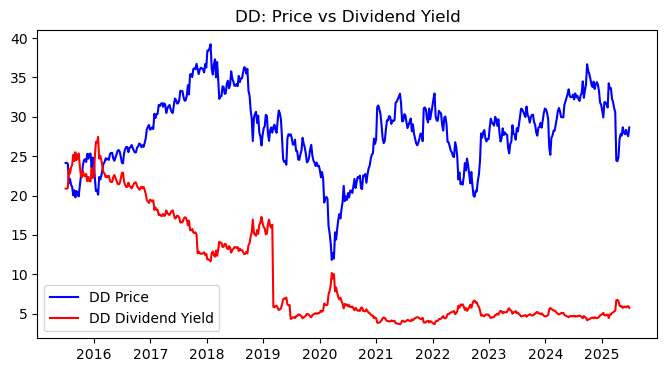

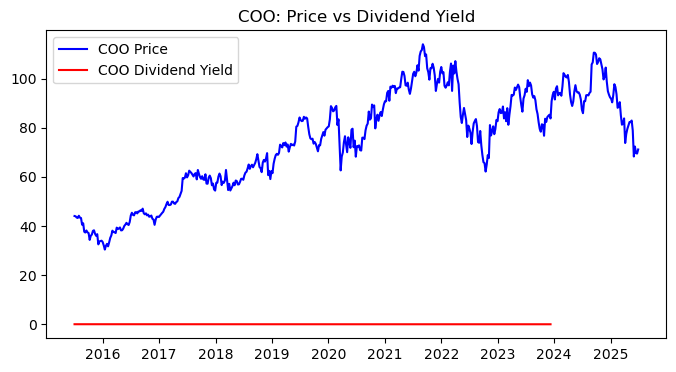

In [37]:
for tick in [max_ticker, min_ticker]:
    plt.figure(figsize=(8,4))
    plt.plot(price[tick], label=f'{tick} Price', color='blue')
    plt.plot(dvd_yld[tick], label=f'{tick} Dividend Yield', color='red')
    plt.title(f'{tick}: Price vs Dividend Yield')
    plt.legend()
    plt.show()

Looking at the plots, we see the highest 1-year average dividend-yield stock was DD, and the lowest was COO. For DD, the spike in dividend yield coincides with both a sharp rise in dividends and a sharp drop in price in 2016. This indicates that the high dividend yield was driven by both a fall in price and a rise in dividends. That is, it seems to be a result of changes in both D and P (hard to isolate the effects of one or the other).

For COO, the dividend yield remained near zero throughout the sample, while the price was generally increasing (i.e., trended upward) throughout the sample. Thus, the low dividend yield was driven entirely by changes in P, and we clearly see that the date of the min dividend yield in 2022 corresponds to the highest price of COO.

### 1.2. A Carry Strategy
For this strategy, use the dvd yld data.

Build a portfolio where at every time $t$, you set weights, $w_t$, that invest…
- long the highest ranking 20% stocks.

For now, go equal weights of 0.01 in any stock for which you’re long or short.

### Realized Returns
Start at the beginning of the sample.
- At time $t$, rank the stocks.
- The selected stocks will earn $r_{t+1}$.

In [41]:
ret = price.pct_change().shift(-1)
dvd_yld = dvd_yld.iloc[:-1]
ret = ret.iloc[:-1]

weights = dvd_yld.copy() * 0
for t in dvd_yld.index:
    row = dvd_yld.loc[t].dropna()
    n = len(row)
    k = int(0.2 * n)

    top = row.nlargest(k).index
    weights.loc[t, top] =  0.01

carry_ret = (weights * ret).sum(axis=1)

### 1.3. Long-Short
Re-do the strategy of the previous section, but this time go long and short…

At any given time $t$, set the vector $w_t$ as follows…
- long the highest-ranking 20% of stocks.
- short the lowest-ranking 20% of stocks.
- take no position in all other stocks.

In [42]:
weights_ls = dvd_yld.copy() * 0
for t in dvd_yld.index:
    row = dvd_yld.loc[t].dropna()
    n = len(row)
    k = int(0.2 * n)

    top = row.nlargest(k).index
    bot = row.nsmallest(k).index
    weights_ls.loc[t, top] =  +0.01
    weights_ls.loc[t, bot] =  -0.01

carry_ls_ret = (weights_ls * ret).sum(axis=1)

### 1.4. Performance
Calculate the return of your portfolio over time.

Report the following annualized stats
- mean
- volatility
- Sharpe

Also calculate the tail-risk stats
- skewness
- VaR (5th quantile)
- CVaR (5th quantile)
- max drawdown

For both tables, compare to SPY, found in the additional data tab.

In [40]:
def perf(rets):
    if isinstance(rets, pd.Series):
        rets = rets.to_frame()

    mu = rets.mean() * 52
    vol = rets.std() * np.sqrt(52)

    cum = (1 + rets).cumprod()
    peak = cum.cummax()
    dd = (cum - peak) / peak

    return pd.DataFrame({
        'Mean': mu,
        'Vol': vol,
        'Sharpe': mu / vol,
        'Skew': rets.skew(),
        'VaR 5%': rets.quantile(0.05),
        'CVaR 5%': rets.apply(lambda x: x[x <= x.quantile(0.05)].mean()),
        'Max DD': dd.min(),
    })

In [44]:
spy_price = additional_data.xs('PX_LAST', axis=1, level=1)['SPY']
spy_ret = spy_price.pct_change().shift(-1)

rets = pd.DataFrame({
    'Carry (long only)': carry_ret,
    'Carry (long-short)': carry_ls_ret,
    'SPY': spy_ret
}).dropna()

perf(rets).round(4)

,Mean,Vol,Sharpe,Skew,VaR 5%,CVaR 5%,Max DD
Carry (long only),0.1104,0.1627,0.6787,0.2772,-0.0286,-0.0496,-0.3601
Carry (long-short),-0.0037,0.0951,-0.0393,1.0888,-0.0185,-0.0273,-0.2409
SPY,0.1408,0.1732,0.8131,-0.5950,-0.0336,-0.0568,-0.3183


# 2. Attribution
### 2.1. Market Exposure
For both the long-only (LO) and long-short (LS) strategies, estimate a linear factor decomposition (LFD) against SPY

Report the…
- alpha (annualized)
- beta
- r-squared

Also show the correlation matrix of the strategies.

How do the LO and LS strategies compare to SPY?

In [49]:
def lfd(y, x):
    df = pd.concat([y, x], axis=1).dropna()
    y = df.iloc[:, 0]
    x = df.iloc[:, 1]
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()

    return pd.Series({
        'alpha (annualized)': model.params['const'] * 52,
        'beta': model.params['SPY'],
        'R2': model.rsquared
    }, name=y.name)

lo_lfd = lfd(rets['Carry (long only)'], rets['SPY'])
ls_lfd = lfd(rets['Carry (long-short)'], rets['SPY'])
pd.concat([lo_lfd, ls_lfd], axis=1).T.round(4)

,alpha (annualized),beta,R2
Carry (long only),0.0037,0.7579,0.6513
Carry (long-short),0.0001,-0.0273,0.0025


In [50]:
rets.corr()

,Carry (long only),Carry (long-short),SPY
Carry (long only),1.000000,0.504211,0.807021
Carry (long-short),0.504211,1.000000,-0.049801
SPY,0.807021,-0.049801,1.000000


The long-only carry strategy exhibits a meaningful exposure to the market. Its estimated beta is approximately 0.76, indicating that the strategy moves with SPY (i.e., is highly correlated with the market). We also see a strong positive correlation between the returns of the long-only strategy and SPY in the correlation matrix (roughly 0.81). The high $R^2$ of roughly 0.65 indicates that roughly 65% of the variation in weekly returns of the long-only carry strategy can be explained by movements in the market (SPY). Finally, there is a small annualized alpha of roughly 0.004, which further reinforces the idea that the long-only carry strategy does not offer returns that are uncorrelated to the market. Overall, the long-only strategy essentially offers nothing (in terms of returns) beyond what SPY provides.

In contrast, the long–short carry strategy has limited exposure to the market. Its estimated beta is nearly zero (rouighly –0.03) and its correlation to SPY is about -0.05, meaning the strategy's returns are uncorrelated to market returns. The $R^2$ is extremely low (0.0025), indicating that SPY explains very little of the observed variance in the weekly returns of the long-short strategy. However, the long-short strategy has an even smaller annualized alpha (0.0001) than the long-only strategy. In summary, while the long-short carry strategy is not exposed to the market, it also does not provide meaningful excess returns uncorrelated from market returns. 

### 2.2. Sector Regression
Estimate a multivariate LFD for both LO and LS against all the sector ETFs.
- Note that SHV is not a sector ETF but rather a money-market fund. Exclude it.
- Exclude SPY.

Report the same stats as in 2.1.

In [53]:
sector_price = sector_data.xs('PX_LAST', axis=1, level=1)
sector_ret = sector_price.pct_change().shift(-1)

def mv_lfd(y, x):
    df = pd.concat([y, x], axis=1).dropna()
    y = df.iloc[:, 0]
    x = df.iloc[:, 1:]
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()

    res = pd.Series(name=y.name)
    res['alpha (annualized)'] = model.params['const'] * 52
    res['R2'] = model.rsquared
    for name in X.columns:
        if name != 'const':
            res[f'beta_{name}'] = model.params[name]
    return res

lo_sec = mv_lfd(rets['Carry (long only)'], sector_ret)
ls_sec = mv_lfd(rets['Carry (long-short)'], sector_ret)
pd.concat([lo_sec, ls_sec], axis=1).T.round(4)

,alpha (annualized),R2,beta_XLK,beta_XLI,beta_XLF,beta_XLC,beta_XLRE,beta_XLE,beta_XLY,beta_XLB,beta_XLV,beta_XLU,beta_XLP
Carry (long only),0.0248,0.9312,-0.0995,0.1009,0.2429,0.0607,0.2574,0.1243,-0.0103,0.0784,-0.0675,0.1244,-0.0048
Carry (long-short),0.0234,0.6401,-0.2484,-0.1278,0.2102,0.0557,0.2095,0.1065,-0.1001,0.0002,-0.2406,0.1471,0.0304


### 2.3. Sector Neutrality
Is your LO or LS implementation of the carry strategy neutral to sectors? To which sector does it have the largest exposure?

Remember    
Unless regressors are standardized, comparing betas directly can be misleading. You might consider comparing $\beta_i \sigma_i$ when deciding which exposure is most substantial.

In [56]:
sector_vol = sector_ret.std()

lo_betas = lo_sec.filter(like='beta_')
ls_betas = ls_sec.filter(like='beta_')

sectors = lo_betas.index.str.replace('beta_', '')
lo_beta_sigma = lo_betas.values * sector_vol[sectors].values
ls_beta_sigma = ls_betas.values * sector_vol[sectors].values

pd.DataFrame({
    'sigma': sector_vol[sectors].values,
    'LO_beta': lo_betas.values,
    'LO_beta_sigma': lo_beta_sigma,
    'LS_beta': ls_betas.values,
    'LS_beta_sigma': ls_beta_sigma,
}, index=sectors).round(4)

,sigma,LO_beta,LO_beta_sigma,LS_beta,LS_beta_sigma
XLK,0.0304,-0.0995,-0.0030,-0.2484,-0.0075
XLI,0.0284,0.1009,0.0029,-0.1278,-0.0036
XLF,0.0311,0.2429,0.0075,0.2102,0.0065
XLC,0.0287,0.0607,0.0017,0.0557,0.0016
XLRE,0.0298,0.2574,0.0077,0.2095,0.0062
XLE,0.0411,0.1243,0.0051,0.1065,0.0044
XLY,0.0299,-0.0103,-0.0003,-0.1001,-0.0030
XLB,0.0290,0.0784,0.0023,0.0002,0.0000
XLV,0.0233,-0.0675,-0.0016,-0.2406,-0.0056
XLU,0.0267,0.1244,0.0033,0.1471,0.0039


Neither the long-only or long–short carry strategy is sector-neutral. Looking at the scaled sector exposures, $\beta_i \sigma_i$, we see that both strategies are still meaningfully exposed to XLRE (Real Estate), XLF (Financials), and XLE (Energy). The values of $\beta_i \sigma_i$ for these three sectors for each of the two strategies are positive and large in magnitude relative to the values of $\beta_i \sigma_i$ for the other sectors. The long-short strategy also exhibits large (in magnitude) negative exposure to XLK (technology), with its value of $\beta_i \sigma_i$ being more than double the value for the long-only strategy. 

There are other sectors where each strategy has meaningful exposure (e.g., XLV for long-short, moderate exposure to XLU for both, etc.), but for brevity's sake, the most significant findings (discussed above) already illustrate the overall findings seen in the whole table: the strategies are not sector-neutral, as they very clearly do not have limited (small in magnitude) exposure to every sector after controlling for the others.

### 2.4. Magnificent Seven
Construct an equally-weighted portfolio of the following tickers. Call this MAG. Estimate a LFD on both SPY and MAG. Do this for both the LO and LS strategies.

Report the stats from 2.1.

Comment on what you conclude from this regression.

['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'META', 'TSLA']

In [57]:
mag = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'NVDA', 'TSLA']
mag_price = price[mag]
mag_ret = mag_price.pct_change().shift(-1).mean(axis=1)

X = pd.concat([mag_ret, spy_ret], axis=1).dropna()
X.columns = ['MAG', 'SPY']

lo_mag = mv_lfd(rets['Carry (long only)'], X)
ls_mag = mv_lfd(rets['Carry (long-short)'], X)

pd.concat([lo_mag, ls_mag], axis=1).T.round(4)

,alpha (annualized),R2,beta_MAG,beta_SPY
Carry (long only),0.0656,0.7662,-0.3629,1.2192
Carry (long-short),0.0476,0.2003,-0.2783,0.3264


The regression of the carry strategies on MAG and SPY indicates similar takeaways as the regression of the strategies on just SPY in 2.1, with some noteworthy differences. Firstly, we see again that the long-only carry strategy has strong correlation to the market, with $\beta_{\text{SPY}} \approx 1.22$, with more limited exposure to MAG: $\beta_{\text{MAG}} \approx -0.36$. This is interesting because MAG stocks are intuitively a dominant component of SPY; so, the long-only carry strategy behaves like the market, but not MAG. The $R^2$ of roughly 0.77 is an increase of about 0.12 from the SPY-only LFD in 2.1, meaning adding the MAG factor improves the portion of variation in long-only returns explained by the model by a non-negligible amount. Simply put: this weaker negative correlation with MAG is a pretty important feature of the long-only carry strategy. All of the above suggests that the long-only strategy would be good for someone who is bullish on the market overall, but bearish on big tech (i.e., MAG companies).

The long–short carry strategy still has limited exposure to the market like in 2.1 ($\beta_{\text{SPY}} \approx 0.33$). Further, the long-short strategy has weaker exposure to MAG than the long-only strategy: $\beta_{\text{MAG}} \approx -0.28$ < -0.36$ in magnitude (i.e., |-0.28| < |-0.36|). This essentially reinforces the findings from 2.1 even further: MAG is a dominant component of SPY, and the long-short strategy returns are not significantly correlated to MAG or SPY. Finally, the low $R^2$ of about 0.2 is a significant imporvement from the $R^2$ of 0.0025 in the SPY-only LFD, meaning adding MAG does help to explain a greater portion of the variation seen in long-short returns (it's just that $\beta_{\text{MAG}}$ suggests that long-short returns are not significantly exposed to MAG).

Finally, both strategies have higher annualized alpha than in the SPY-only LFD in 2.1, which is inline with the negative betas for MAG: both strategies tilt against MAG, so assuming there exist some positive strategy returns (and assuming that buying and holding MAG would have had positive returns in the sample period), negative $\beta_{\text{MAG}}$ for both strategies means positive strategy returns will not be correlated to MAG once MAG is added to the model.

# 3. Dynamic hedged
It’s one thing to ex-post evaluate whether the strategy had alpha beyond sector exposures. That raises the question as to whether we can caputre that when we’re imperfectly hedging the sector exposure in real time.

At each date we:
1. Look back over a rolling 5-year window of weekly data.
2. Regress the portfolio return on the sector ETF returns.
3. Use the estimated betas as hedge ratios going forward one step.
4. Form a sector-hedged return by combining the strategy with an offsetting position in the sector ETFs.

We do this for both the long-only and long-short variants.

### 3.1.
Report the univariate stats of the hedged strategies.

In [59]:
idx = rets['Carry (long only)'].index
lo_hedged = []
ls_hedged = []

for t in range(260, len(idx)-1):
    end = idx[t]
    start = idx[t-260]
    X = sector_ret.loc[start:end]

    y_lo = rets['Carry (long only)'].loc[start:end]
    model_lo = sm.OLS(y_lo, X, missing='drop').fit()
    betas_lo = model_lo.params

    y_ls = rets['Carry (long-short)'].loc[start:end]
    model_ls = sm.OLS(y_ls, X, missing='drop').fit()
    betas_ls = model_ls.params

    next_t = idx[t+1]
    sec_next = sector_ret.loc[next_t]

    lo_val = rets['Carry (long only)'].loc[next_t] - (betas_lo * sec_next).sum()
    ls_val = rets['Carry (long-short)'].loc[next_t] - (betas_ls * sec_next).sum()

    lo_hedged.append((next_t, lo_val))
    ls_hedged.append((next_t, ls_val))

lo_hedged = pd.Series(dict(lo_hedged), name='LO_hedged')
ls_hedged = pd.Series(dict(ls_hedged), name='LS_hedged')
hedged_df = pd.concat([lo_hedged, ls_hedged], axis=1).dropna()
perf(hedged_df).round(4)

,Mean,Vol,Sharpe,Skew,VaR 5%,CVaR 5%,Max DD
LO_hedged,0.0028,0.0525,0.0524,0.2518,-0.0104,-0.0141,-0.0765
LS_hedged,-0.0067,0.0696,-0.0963,0.3973,-0.0145,-0.0184,-0.1100


### 3.2.
Report sector LFD of the sector-hedged strategies.

In [60]:
lo_sec_hedged = mv_lfd(hedged_df['LO_hedged'], sector_ret)
ls_sec_hedged = mv_lfd(hedged_df['LS_hedged'], sector_ret)
pd.concat([lo_sec_hedged, ls_sec_hedged], axis=1).T.round(4)

,alpha (annualized),R2,beta_XLK,beta_XLI,beta_XLF,beta_XLC,beta_XLRE,beta_XLE,beta_XLY,beta_XLB,beta_XLV,beta_XLU,beta_XLP
LO_hedged,0.0167,0.2428,0.0359,-0.0102,-0.0250,-0.0203,0.0382,-0.0238,-0.0363,-0.0626,0.0591,-0.1270,0.1450
LS_hedged,0.0080,0.1692,0.0288,-0.0147,-0.0502,-0.0157,0.0492,-0.0090,-0.0134,-0.0980,0.0386,-0.1261,0.1858


# 4. Assessing the Forecast
Up to this point we did not build an explicit return forecast; we jumped straight from a signal (dividend yield) to positions.

We could introduce the intermediate step of the return forecasts to try to understand whether the performance is driven by forecasting vs positioning. For illustration, consider the following forecasts:
- +0.1% for stocks we go long (top sorted)
- −0.1% for stocks we short (bottom sorted).


### 4.1.
- Treat those implied forecasts as a cross-sectional predictor of next-period returns.
- Compute an “out-of-sample” $R^2$ for the forecast vs realized returns.
- Compute the correlation between the forecast and realized returns.

In [62]:
forecast = dvd_yld.copy() * np.nan
for t in dvd_yld.index:
    row = dvd_yld.loc[t].dropna()
    n = len(row)
    k = int(0.2 * n)

    top = row.nlargest(k).index
    bot = row.nsmallest(k).index

    forecast.loc[t, top] =  +0.001
    forecast.loc[t, bot] =  -0.001


realized_ret = price.pct_change().shift(-1)
common_idx = forecast.index.intersection(realized_ret.index)
F = forecast.loc[common_idx]
R = realized_ret.loc[common_idx]

cs_R2 = []

for t in common_idx[:-1]:
    f_t = F.loc[t]
    r_t1 = R.shift(-1).loc[t]
    mask = f_t.notna() & r_t1.notna()

    f = f_t[mask]
    r = r_t1[mask]
    denom = ((r - r.mean())**2).sum()
    num   = ((r - f)**2).sum()

    cs_R2.append(num/denom if denom != 0 else np.nan)

cs_R2 = pd.Series(cs_R2, index=common_idx[:-1], name='OOS_R2')

cs_corr = []

for t in common_idx[:-1]:
    f = F.loc[t]
    r = R.shift(-1).loc[t]
    mask = f.notna() & r.notna()
    cs_corr.append(f[mask].corr(r[mask]))

cs_corr = pd.Series(cs_corr, index=common_idx[:-1], name='OOS_corr')

pd.DataFrame({
    'mean_R2': [cs_R2.mean()],
    'median_R2': [cs_R2.median()],
    'mean_corr': [cs_corr.mean()],
    'median_corr': [cs_corr.median()]
}).round(4)

,mean_R2,median_R2,mean_corr,median_corr
0,1.4545,1.1568,-0.0081,-0.0077


### 4.2.
In section 3, we considered a hedged strategies. Repeat 4.1 but this time interpreting our forecasts as pertaining to the hedged residuals of an LFD.

That is, build the forecasts identically, but compare them to the realized $\epsilon_t$ rather than the realized $r_t$.

Use SPY as the single hedging factor. Be careful to estimate $\epsilon_t$ each period with data up to that point in time, rather than using the full sample.

In [68]:
cov_spy = realized_ret.rolling(260).cov(spy_ret) # Rolling cov(stock, SPY) for all stocks
var_spy = spy_ret.rolling(260).var() # Rolling var(SPY)
betas_spy = cov_spy.div(var_spy, axis=0) # Rolling beta for each stock
resid_spy = realized_ret - betas_spy.shift(1).mul(spy_ret, axis=0) # epsilon_t = r_t - beta_{t-1} * spy_t

cs_R2_spy = []
cs_corr_spy = []
for t in common_idx[:-1]:
    f = forecast.loc[t]
    e = resid_spy.shift(-1).loc[t]

    mask = f.notna() & e.notna()
    if mask.sum() == 0:
        cs_R2_spy.append(np.nan)
        cs_corr_spy.append(np.nan)
        continue

    num = ((e[mask] - f[mask])**2).sum()
    denom = ((e[mask] - e[mask].mean())**2).sum()
    R2 = 1 - num/denom if denom != 0 else np.nan

    cs_R2_spy.append(R2)
    cs_corr_spy.append(f[mask].corr(e[mask]))


cs_R2_spy = pd.Series(cs_R2_spy, index=common_idx[:-1])
cs_corr_spy = pd.Series(cs_corr_spy, index=common_idx[:-1])

pd.DataFrame({
    'mean_R2': [cs_R2_spy.mean()],
    'median_R2': [cs_R2_spy.median()],
    'mean_corr': [cs_corr_spy.mean()],
    'median_corr': [cs_corr_spy.median()],
}).round(4)

,mean_R2,median_R2,mean_corr,median_corr
0,-0.0981,-0.0474,0.0006,0.0041


### 4.3.
Repeat 4.2. but considering all the sectors as the LFD.

In [70]:
resid_sec = realized_ret.copy() * np.nan

for t in range(260, len(common_idx) - 1):
    end   = common_idx[t]
    start = common_idx[t - 260]

    X = sector_ret.loc[start:end].dropna()
    R = realized_ret.loc[start:end].loc[X.index]

    if len(X) < 5:
        continue

    XtX_inv = np.linalg.inv(X.T @ X)
    betas_mat = XtX_inv @ (X.T @ R)

    t1 = common_idx[t + 1]
    x_next = sector_ret.loc[t1].values.reshape(-1, 1)

    predicted = (betas_mat.T.to_numpy() @ x_next).reshape(-1)

    resid_sec.loc[t1] = realized_ret.loc[t1] - predicted

cs_R2_sec = []
cs_corr_sec = []
for t in common_idx[:-1]:
    f = forecast.loc[t]
    e = resid_sec.shift(-1).loc[t]

    mask = f.notna() & e.notna()

    if mask.sum() == 0:
        cs_R2_sec.append(np.nan)
        cs_corr_sec.append(np.nan)
        continue

    num   = ((e[mask] - f[mask])**2).sum()
    denom = ((e[mask] - e[mask].mean())**2).sum()
    R2 = 1 - num/denom if denom != 0 else np.nan

    cs_R2_sec.append(R2)

    cs_corr_sec.append(f[mask].corr(e[mask]))

cs_R2_sec  = pd.Series(cs_R2_sec,  index=common_idx[:-1])
cs_corr_sec = pd.Series(cs_corr_sec, index=common_idx[:-1])

pd.DataFrame({
    'mean_R2':     [cs_R2_sec.mean()],
    'median_R2':   [cs_R2_sec.median()],
    'mean_corr':   [cs_corr_sec.mean()],
    'median_corr': [cs_corr_sec.median()],
}).round(4)

,mean_R2,median_R2,mean_corr,median_corr
0,-0.02,-0.0151,-0.0076,-0.0077


# 5. No-Arbitrage via Cross-Asset Replication
If an asset can be replicated by other assets, an arbitrage-free model should assign consistent forecasts to the asset and its replication portfolio.

### 5.1. LASSO Replication and Forecast Consistency
For a selected asset, use LASSO to find a replication portfolio. Compare the dividend-yield-based forecast for the target asset vs its replication portfolio.

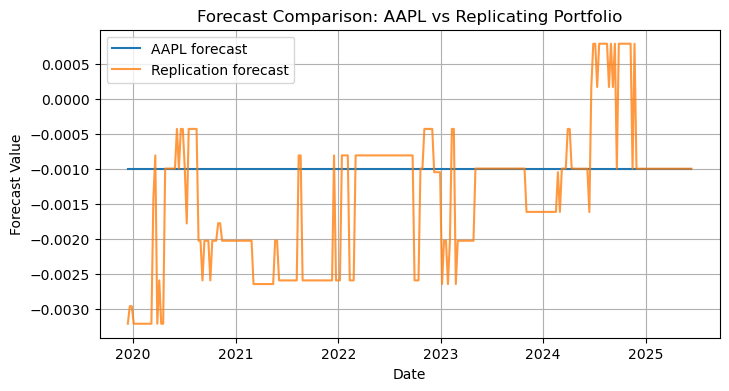

In [76]:
target = 'AAPL'
y = realized_ret[target]
X = realized_ret.drop(columns=[target])
df = pd.concat([y, X], axis=1).dropna()
y_clean = df.iloc[:, 0]
X_clean = df.iloc[:, 1:]
X_std = (X_clean - X_clean.mean()) / X_clean.std()
y_std = (y_clean - y_clean.mean()) / y_clean.std()

lasso = LassoCV(cv=5, fit_intercept=False).fit(X_std, y_std)

rep_weights_std = pd.Series(lasso.coef_, index=X_clean.columns)
rep_weights = rep_weights_std / X_clean.std()
valid = rep_weights.index.intersection(forecast.columns)
rep_weights = rep_weights.loc[valid]

rep_ret = (realized_ret[rep_weights.index] * rep_weights).sum(axis=1)
rep_ret.name = "rep_ret"

f_stock = forecast[target]
f_rep = (forecast[rep_weights.index] * rep_weights).sum(axis=1)

df_plot = pd.DataFrame({'stock_forecast': f_stock, 'rep_forecast': f_rep}).dropna()

plt.figure(figsize=(8,4))
plt.plot(df_plot.index, df_plot['stock_forecast'], label=f'{target} forecast')
plt.plot(df_plot.index, df_plot['rep_forecast'], label='Replication forecast', alpha=0.8)
plt.title(f'Forecast Comparison: {target} vs Replicating Portfolio')
plt.xlabel('Date')
plt.ylabel('Forecast Value')
plt.legend()
plt.grid(True)
plt.show()

### 5.2. Arbitrage
Do your forecasts imply arbitrage?

To test for arbitrage, we compare the forecast for the target asset to the forecast for its LASSO replication portfolio. In an arbitrage-free setting, these portfolios with extremely similar returns (by construction), should have similar forcasts. However, the forecasts differ significantly as we can see, meaning the forecasting method we use essentially imposes different expected returns on two portfolios that should be more-or-less the same.

In our results, the target asset’s forecast is nearly constant because the dividend-yield rule only produces the values +0.1%, 0, or -0.1%, while the replication portfolio’s forecast varies substantially. Since the replication portfolio closely matches the asset’s realized returns, but the forecasts are different, these forecasts imply arbitrage.